In [1]:
# libraries 
import numpy as np
import numpy.matlib
import cvxpy
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import time
import scipy
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import random
from scipy import stats
import torch
import math
import sklearn.linear_model
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import scipy.io as sio
import torch.nn.functional as F
from sklearn import svm
from sklearn.datasets import make_blobs

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs

In [2]:
from data_utils import get_CIFAR10_data
# Load the (preprocessed) CIFAR-10 data.
data = get_CIFAR10_data()
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")


X_train: (49000, 3, 32, 32)
y_train: (49000,)
X_val: (1000, 3, 32, 32)
y_val: (1000,)
X_test: (1000, 3, 32, 32)
y_test: (1000,)


In [3]:
def generate_sign_patterns(X, P, verbose=False): 
    """ 
    Inputs: X (input to the layer), P (number of samples, also number of neurons)
    Outputs: P, [D_1,...D_P], [u_1,...,u_P]
             where each D is Diag(1[X@u_i>=0]), u_i a random vector
    See remark 3.3 in (Pilanci&Ergen 2020)
    "The convex program (8) can be approximated by sampling a set
     of diagonal matrices D_1,...,D_P"
    """
    n, d = X.shape
    sign_pattern_list = []  # sign patterns, stores D_1,...,D_P
    u_vector_list = []      # random vectors used to generate the sign patterns

    for i in range(P): 
        # Obtain a sign pattern
        # Future work: use a different sampling distribution than Gaussian
        
        # First, sample u from normal distribution
        u = np.random.normal(0, 1, (d,1)) 
        
        # Our sign pattern is Diag(1[X@u_i>=0])
        sampled_sign_pattern = (np.matmul(X, u) >= 0)[:,0]
        
        sign_pattern_list.append(sampled_sign_pattern)
        u_vector_list.append(u)
    if verbose:
        print("Number of sign patterns generated: " + str(len(sign_pattern_list)))
    return len(sign_pattern_list), sign_pattern_list, u_vector_list

def generate_u_vectors_manual(prev_dim, P, verbose=False): 
    
    d = prev_dim
    u_vector_list = []      # random vectors used to generate the sign patterns

    for i in range(P): 
        # Obtain a sign pattern
        # Future work: use a different sampling distribution than Gaussian
        
        # First, sample u from normal distribution
        u = np.random.normal(0, 1, (d,1)) 
        
        u_vector_list.append(u)
    if verbose:
        print("Number of sign patterns generated: " + str(len(u_vector_list)))
    return u_vector_list

def one_hot(labels, num_classes=10):
    """Embedding labels to one-hot form.

    Args:
      labels: (LongTensor) class labels, sized [N,].
      num_classes: (int) number of classes.

    Returns:
      (tensor) encoded labels, sized [N, #classes].
    """
    y = torch.eye(num_classes) 
    return y[labels.long()] 

class PrepareData(Dataset):
    #  converts data from numpy array to torch tensor
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class PrepareData3D(Dataset):
    def __init__(self, X, y):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
        else:
            self.X = X
            
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)
        else:
            self.y = y
        
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [19]:
class custom_cvx_layer_multilayer(torch.nn.Module):
    def __init__(self, n, d, num_neurons_list, u_vector_array, num_layers=1, num_classes=10, batchmomentum=0.1):
        super(custom_cvx_layer_multilayer, self).__init__()
        assert len(num_neurons_list) == num_layers
        assert len(u_vector_array) == num_layers
        
        self.num_layers = num_layers
        self.out_layer = 0
        self.v_list = torch.nn.ParameterList()
        self.w_list = torch.nn.ParameterList()
        self.h_list = torch.nn.ParameterList()
        self.batchnorm_list = []
        
        for i in range(num_layers):
            if i == 0:
                prev_dimension = d
            else:
                prev_dimension = num_neurons_list[i - 1] 
            
            # using Xavier initialization 
            if True: #i == 0:
                v_data = torch.zeros(num_neurons_list[i], prev_dimension, num_classes)
                w_data = torch.zeros(num_neurons_list[i], prev_dimension, num_classes)
            else:
                # Xavier initialization
                v_data = torch.randn(num_neurons_list[i], prev_dimension, num_classes) * math.sqrt(1 / prev_dimension)
                w_data = torch.randn(num_neurons_list[i], prev_dimension, num_classes) * math.sqrt(1 / prev_dimension)
                
            self.v_list.append(torch.nn.Parameter(data=v_data, requires_grad=True))
            self.w_list.append(torch.nn.Parameter(data=w_data, requires_grad=True))
            
            u_vectors_as_np = np.float32(np.asarray(u_vector_array[i]).reshape((num_neurons_list[i], -1)).T)
            self.h_list.append(torch.nn.Parameter(data=torch.tensor(u_vectors_as_np), requires_grad=False))
            # self.batchnorm_list.append(torch.nn.BatchNorm1d(num_neurons_list[i], eps=1e-5, momentum=batchmomentum, affine=False))  # TODO: freeze?

    def set_out_layer(self, layer):
        self.out_layer = layer
        for i in range(self.num_layers):
            if i != layer:
                self.v_list[i].requires_grad = False
                self.w_list[i].requires_grad = False
                # self.batchnorm_list[i].requires_grad = False
            if i == layer:
                self.v_list[i].requires_grad = True
                self.w_list[i].requires_grad = True
                # self.batchnorm_list[i].requires_grad = True
                
    def current_vwh(self):
        v = self.v_list[self.out_layer]
        w = self.w_list[self.out_layer]
        h = self.h_list[self.out_layer]
        return v, w, h
    
    def current_layer_input(self, x, device):
        x = torch.from_numpy(x).to(device).float()
        next_input = x.view(x.shape[0], -1)
        
        for i in range(self.out_layer):
            
            sign_patterns = (torch.matmul(next_input, self.h_list[i]) >= 0).unsqueeze(2)
            Xv_w = torch.matmul(next_input, self.v_list[i] - self.w_list[i])
            DXv_w = torch.mul(sign_patterns, Xv_w.permute(1, 0, 2))
            # DXv_w_batchnormed = self.batchnorm_list[i](DXv_w)
            # next_input = DXv_w_batchnormed
            # next_input = torch.amax(DXv_w, dim=-1)  # Max pooling
            next_input = torch.mean(DXv_w, dim=-1)
            
        #for i in range(self.out_layer):
        #    v_normed = self.v_list[i] / torch.sqrt(torch.linalg.norm(self.v_list[i], dim = -1, keepdims=True))
        #    w_normed = self.w_list[i] / torch.sqrt(torch.linalg.norm(self.w_list[i], dim = -1, keepdims=True))
        #    alpha = torch.cat([v_normed, w_normed], dim=-1).view(v_normed.shape[0], -1)
        #    next_input = F.relu(x @ alpha)
        
        next_input = next_input.detach().cpu().numpy()
        return next_input
    
    def apply_beta_lasso(self, lr, b_lambda, b_beta):
        v = self.v_list[self.out_layer].data
        w = self.w_list[self.out_layer].data
        
        v = v - (lr * b_lambda * torch.sign(v))
        w = w - (lr * b_lambda * torch.sign(w))
        
        w = w * (torch.abs(w) >= b_lambda * b_beta)
        v = v * (torch.abs(v) >= b_lambda * b_beta)

    def forward(self, x):
        # next_input = self.current_layer_input(x)
        next_input = x
        sign_patterns = (torch.matmul(next_input, self.h_list[self.out_layer]) >= 0).unsqueeze(2)
        Xv_w = torch.matmul(next_input, self.v_list[self.out_layer] - self.w_list[self.out_layer])
        DXv_w = torch.mul(sign_patterns, Xv_w.permute(1, 0, 2))
        y_pred = torch.sum(DXv_w, dim=1, keepdim=False)
        return y_pred

def loss_func_cvxproblem_multilayer(yhat, y, model, _x, beta, rho, device):
    """
    This implements the convex problem described by equation (8)
    """
    # term 1, the square-distance loss
    loss = 0.5 * torch.norm(yhat - y)**2/y.shape[0]
    
    # term 2, the regularization term
    v, w, h = model.current_vwh()
    norms1=torch.norm(v, dim=0)
    norms2=torch.norm(w, dim=0)
    loss = loss + beta * torch.sum(norms1)
    loss = loss + beta * torch.sum(norms2)
    
    # term 3, enforces the inequality constraints
    if rho>0:
        #current_input = model.current_layer_input(_x)
        current_input = _x
        sign_patterns = (torch.matmul(current_input, h) >= 0).unsqueeze(2)
        Xv = torch.matmul(current_input, torch.sum(v, dim=2, keepdim=True))
        DXv = torch.mul(sign_patterns, Xv.permute(1, 0, 2))
        relu_term_v = torch.max(-2*DXv + Xv.permute(1, 0, 2), torch.Tensor([0]).to(device))
        loss = loss + rho * torch.sum(relu_term_v)

        Xw = torch.matmul(current_input, torch.sum(w, dim=2, keepdim=True))
        DXw = torch.mul(sign_patterns, Xw.permute(1, 0, 2))
        relu_term_w = torch.max(-2*DXw + Xw.permute(1, 0, 2), torch.Tensor([0]).to(device))
        loss = loss + rho * torch.sum(relu_term_w)
    
    return loss


def validation_cvxproblem_multilayer(model, testloader, beta, rho, device):
    test_loss = 0
    test_correct = 0

    with torch.no_grad():
        for ix, (_x, _y) in enumerate(testloader):
            _x = Variable(_x).float().to(device)
            _y = Variable(_y).float().to(device)
            _x = _x.view(_x.shape[0], -1)

            yhat = model(_x).float()

            loss = loss_func_cvxproblem_multilayer(yhat, one_hot(_y).to(device), model, _x, beta, rho, device)
            test_loss += loss.item()
            test_correct += torch.eq(torch.argmax(yhat, dim=1), _y).float().sum()

    return test_loss, test_correct
    


def sgd_solver_cvxproblem_multilayer(A_train, y_train, A_test, y_test, num_epochs_list, num_neurons_list, beta, 
                       learning_rate, batch_size, rho, u_vector_array, verbose=False, device='cuda'):
    
    device = torch.device(device)

    n, d = A_train.shape
    
    # create the model
    num_layers = len(num_neurons_list)
    model = custom_cvx_layer_multilayer(n, d, num_neurons_list, u_vector_array, num_layers).to(device)
    
    # arrays for saving the accuracy
    epochs_length = np.sum(np.array(num_epochs_list))
    losses = np.zeros((num_layers, int(epochs_length*np.ceil(A_train.shape[0] / batch_size)))) 
    accs = np.zeros(losses.shape)
    
    losses_test = np.zeros((num_layers, epochs_length+1))
    accs_test = np.zeros((num_layers, epochs_length+1))

    
    times = np.zeros((losses.shape[1] * num_layers + 1))
    times[0] = time.time()
    
    time_iter = 0
    for L in range(num_layers):
        print("Training layer ", L, " with learning rate ", learning_rate[L])
        model.set_out_layer(L)
        
        # prep current_inputs
        train_input = model.current_layer_input(A_train, device)
        test_input = model.current_layer_input(A_test, device)
        
        # column normalization
        if L > 0:
            train_input = (train_input - np.mean(train_input, axis=0, keepdims=True)) / np.std(train_input, axis=0, keepdims=True)
            test_input = (test_input - np.mean(test_input, axis=0, keepdims=True)) / np.std(test_input, axis=0, keepdims=True)
        
        # dataset loaders (minibatch)
        ds = PrepareData3D(X = train_input, y=y_train)
        ds = DataLoader(ds, batch_size=batch_size, shuffle=True)
        ds_test = PrepareData3D(X=test_input, y=y_test)
        ds_test = DataLoader(ds_test, batch_size=A_test.shape[0], shuffle=False) # note batch_size
        
        model.eval()
        losses_test[L][0], accs_test[L][0] = validation_cvxproblem_multilayer(model, ds_test, beta, rho, device) # loss on the entire test set
        iter_no = 0
                                                   
        # new optimizer to reset momentum so that it doesn't update frozen layers
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate[L])
        # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate[L])
        
        num_epochs = num_epochs_list[L]
        
        for i in range(num_epochs):
            model.train()
            for ix, (_x, _y) in enumerate(ds):
                #=========make input differentiable=======================
                _x = Variable(_x).float().to(device)
                _y = Variable(_y).float().to(device)

                #========forward pass=====================================
                yhat = model(_x).float()
                
                loss = loss_func_cvxproblem_multilayer(yhat, one_hot(_y).to(device), model, _x, beta, rho, device)
                correct = torch.eq(torch.argmax(yhat, dim=1), _y).float().sum() # accuracy

                #=======backward pass=====================================
                optimizer.zero_grad() # zero the gradients on each pass before the update
                loss.backward() # backpropagate the loss through the model
                optimizer.step() # update the gradients w.r.t the loss
                
                # beta lasso step 
                # model.apply_beta_lasso(lr = learning_rate[L], b_lambda = 1e-5, b_beta = 50)

                losses[L][iter_no] = loss.item() # loss on the minibatch
                accs[L][iter_no] = correct

                iter_no += 1
                time_iter += 1
                times[time_iter] = time.time()

            model.eval()
            # get test loss and accuracy
            losses_test[L][i+1], accs_test[L][i+1] = validation_cvxproblem_multilayer(model, ds_test, beta, rho, device) # accuracy on the entire test set

            if i % 1 == 0:
                print("Epoch [{}/{}], TRAIN: cvx loss: {} acc: {}. TEST: cvx loss: {} acc: {}".format(i, num_epochs,
                    np.round(losses[L][iter_no-1], 3), np.round(accs[L][iter_no-1]/batch_size, 3), 
                    np.round(losses_test[L][i+1], 3), np.round(accs_test[L][i+1]/A_test.shape[0], 3)))
            
    return accs/batch_size, accs_test/A_test.shape[0], times, model, losses, losses_test

In [5]:
# cifar-10 -- using the version downloaded from "http://www.cs.toronto.edu/~kriz/cifar.html"
# A=sio.loadmat('CIFAR10_multiclass.mat')['A']
# A_test=sio.loadmat('CIFAR10_multiclass.mat')['Atest']
# y=sio.loadmat('CIFAR10_multiclass.mat')['y1']
# y_test=sio.loadmat('CIFAR10_multiclass.mat')['ytest1']

A = data['X_train']
A = A.reshape((A.shape[0], -1))
A_test = data['X_val']
A_test = A_test.reshape((A_test.shape[0], -1))
y = data['y_train']
# y = y.reshape((y.shape[0], 1))
y_test = data['y_val']  
# y_test = y_test.reshape((y_test.shape[0], 1))

meanA=np.mean(A,axis=0)
A=A-meanA
A_test=A_test-meanA


# to get the first two classes only (for binary classification)
# inds = np.argwhere(y <= 1)[:,0] # get the classes 0 and 1
# A = A[inds, :]
# y = y[inds].reshape((inds.shape[0], 1))
# y=2*y.astype(float)-1
# inds_test = np.argwhere(y_test <= 1)[:,0] # get the classes 0 and 1
# A_test = A_test[inds_test, :]
# y_test = y_test[inds_test].reshape((inds_test.shape[0], 1))
# y_test=2*y_test.astype(float)-1


n, d = A.shape
print(A.shape, y.shape, A_test.shape, y_test.shape)


(49000, 3072) (49000,) (1000, 3072) (1000,)


In [8]:
# SGD solver for the nonconvex problem
# generate random sign patterns
P, verbose = 500, True # P is number of sign patterns to generate *and* number of neurons

# num_neurons, sign_pattern_list, u_vector_list = generate_sign_patterns(A, P, verbose)
num_neurons = P
u_vector_list = generate_u_vectors_manual(A.shape[1], P, verbose)
u_vector_list_2 = generate_u_vectors_manual(P, P, verbose)
# u_vector_list_3 = generate_u_vectors_manual(P, P, verbose)
u_vector_array = [u_vector_list, u_vector_list_2]
num_neurons_list = [P, P]

Number of sign patterns generated: 500
Number of sign patterns generated: 500


In [20]:
beta = 1e-3
rho = 1e-6
learning_rates = [1e-7, 1e-6] # one per layer
num_epochs_list = [60, 60]
batch_size = 500

results_cvx = sgd_solver_cvxproblem_multilayer(A, y, A_test, y_test, num_epochs_list, num_neurons_list, beta, 
                       learning_rates, batch_size, rho, u_vector_array, verbose=False)

Training layer  0  with learning rate  1e-07
Epoch [0/60], TRAIN: cvx loss: 0.41 acc: 0.446. TEST: cvx loss: 0.395 acc: 0.456
Epoch [1/60], TRAIN: cvx loss: 0.389 acc: 0.502. TEST: cvx loss: 0.401 acc: 0.477
Epoch [2/60], TRAIN: cvx loss: 0.421 acc: 0.556. TEST: cvx loss: 0.429 acc: 0.474
Epoch [3/60], TRAIN: cvx loss: 0.392 acc: 0.556. TEST: cvx loss: 0.487 acc: 0.449
Epoch [4/60], TRAIN: cvx loss: 0.357 acc: 0.66. TEST: cvx loss: 0.452 acc: 0.462
Epoch [5/60], TRAIN: cvx loss: 0.292 acc: 0.76. TEST: cvx loss: 0.439 acc: 0.463
Epoch [6/60], TRAIN: cvx loss: 0.358 acc: 0.706. TEST: cvx loss: 0.513 acc: 0.414
Epoch [7/60], TRAIN: cvx loss: 0.323 acc: 0.71. TEST: cvx loss: 0.51 acc: 0.439
Epoch [8/60], TRAIN: cvx loss: 0.351 acc: 0.718. TEST: cvx loss: 0.525 acc: 0.438
Epoch [9/60], TRAIN: cvx loss: 0.322 acc: 0.804. TEST: cvx loss: 0.475 acc: 0.446
Epoch [10/60], TRAIN: cvx loss: 0.352 acc: 0.786. TEST: cvx loss: 0.464 acc: 0.465
Epoch [11/60], TRAIN: cvx loss: 0.372 acc: 0.804. TEST: c

Epoch [39/60], TRAIN: cvx loss: 0.144 acc: 0.99. TEST: cvx loss: 0.393 acc: 0.494
Epoch [40/60], TRAIN: cvx loss: 0.147 acc: 0.982. TEST: cvx loss: 0.394 acc: 0.498
Epoch [41/60], TRAIN: cvx loss: 0.148 acc: 0.99. TEST: cvx loss: 0.396 acc: 0.492
Epoch [42/60], TRAIN: cvx loss: 0.142 acc: 0.984. TEST: cvx loss: 0.396 acc: 0.499
Epoch [43/60], TRAIN: cvx loss: 0.14 acc: 0.986. TEST: cvx loss: 0.399 acc: 0.487
Epoch [44/60], TRAIN: cvx loss: 0.138 acc: 0.996. TEST: cvx loss: 0.399 acc: 0.499
Epoch [45/60], TRAIN: cvx loss: 0.137 acc: 0.988. TEST: cvx loss: 0.402 acc: 0.495
Epoch [46/60], TRAIN: cvx loss: 0.135 acc: 0.994. TEST: cvx loss: 0.403 acc: 0.491
Epoch [47/60], TRAIN: cvx loss: 0.138 acc: 0.986. TEST: cvx loss: 0.404 acc: 0.495
Epoch [48/60], TRAIN: cvx loss: 0.13 acc: 0.99. TEST: cvx loss: 0.404 acc: 0.493
Epoch [49/60], TRAIN: cvx loss: 0.125 acc: 0.992. TEST: cvx loss: 0.406 acc: 0.487
Epoch [50/60], TRAIN: cvx loss: 0.13 acc: 0.988. TEST: cvx loss: 0.407 acc: 0.492
Epoch [51/

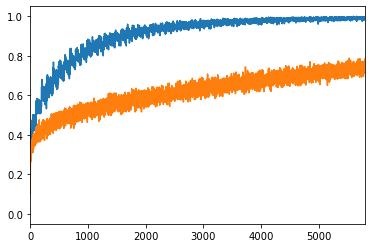

In [17]:
train_accs = results_cvx[0]
for i in range(train_accs.shape[0]):
    plt.plot(train_accs[i])
plt.xlim([0, 5800])
# plt.ylim([0.4, 0.8])
plt.show()

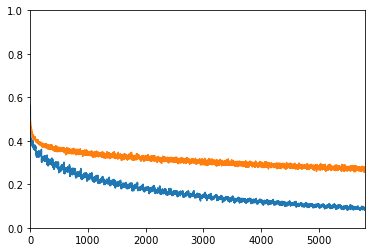

In [11]:
plt.clf()
train_losses = results_cvx[4]
for i in range(train_losses.shape[0]):
    plt.plot(train_losses[i])
plt.xlim([0, 5800])
plt.ylim([0, 1])
plt.show()

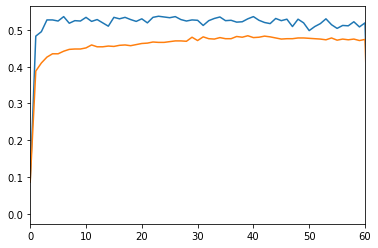

In [12]:
plt.clf()
test_accs = results_cvx[1]
for i in range(test_accs.shape[0]):
    plt.plot(test_accs[i])
plt.xlim([0, 60])
plt.show()

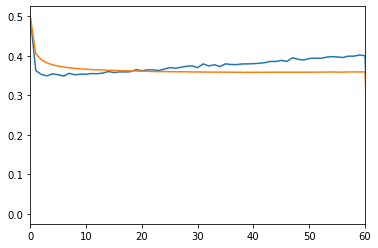

In [13]:
plt.clf()
test_losses = results_cvx[5]
for i in range(test_losses.shape[0]):
    plt.plot(test_losses[i])
plt.xlim([0, 60])
plt.show()